In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix


%matplotlib inline

In [9]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]



In [83]:
def plot_roc_auc(y_test, y_pred):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()
    
def build_model(model, X_train, X_test, y_train, y_test):
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_pred)
    
    f_score = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    ix = np.argmax(f_score)

    plot_roc_auc(y_test, y_pred)
    
    cnf_matrix = confusion_matrix(y_test, y_pred > thresholds[ix])

    return {'precision': precision[ix],
            'recall': recall[ix],
            'f1_score': f_score[ix],
            'roc_auc': roc_auc_score(y_test, y_pred),
            'cv_roc_auc': cv_score,
            'cv_roc_auc_std': cv_score_std,
            'cnf_matrix': cnf_matrix}

In [84]:
!wget 'https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O train_case2.csv

--2022-02-28 14:16:33--  https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Распознаётся drive.google.com (drive.google.com)… 216.58.207.238
Подключение к drive.google.com (drive.google.com)|216.58.207.238|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 303 See Other
Адрес: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7a7rlakv3jk9jesbau427rtsljevcksk/1646046975000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download [переход]
Предупреждение: в HTTP маски не поддерживаются.
--2022-02-28 14:16:34--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7a7rlakv3jk9jesbau427rtsljevcksk/1646046975000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download
Распознаётся doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)… 142.250.74.65
Подключение к doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.goo

In [85]:
df = pd.read_csv('train_case2.csv', ';')

X = df.drop(columns=['cardio'])
y = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

cont_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

cont_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in cont_cols:
    transfomer =  Pipeline([
                ('Selector', NumberSelector(key=cont_col)),
                ('Scaler', StandardScaler())
            ])
    cont_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('Selector', ColumnSelector(key=cat_col)),
                ('OHE', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('Selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

feats = FeatureUnion(cont_transformers+cat_transformers+base_transformers)

### Задание 1

Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

#### Решение

In [86]:
metrics = pd.DataFrame(columns=['precision', 'recall', 'f1_score', 'roc_auc', 'cv_roc_auc', 'cv_roc_auc_std', 'cnf_matrix'])



In [87]:
#Логистическая регрессия
clf_logreg = Pipeline([
    ('Features', feats),
    ('Classifier', LogisticRegression(random_state=42)),
])

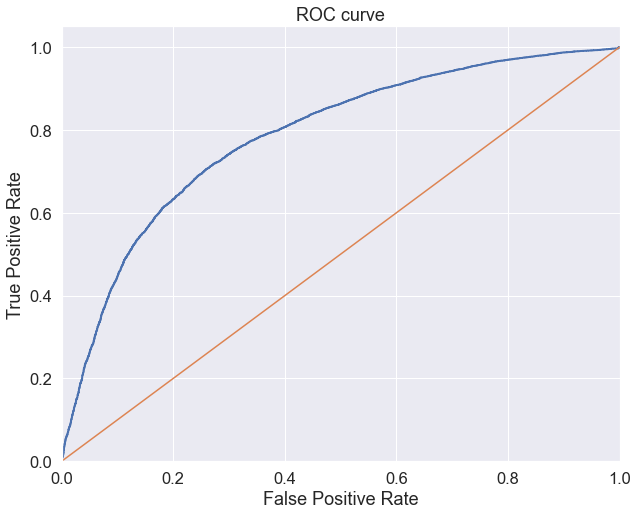

In [88]:
metrics_logreg = build_model(clf_logreg, X_train, X_test, y_train, y_test)
metrics = metrics.append(metrics_logreg, ignore_index=True)

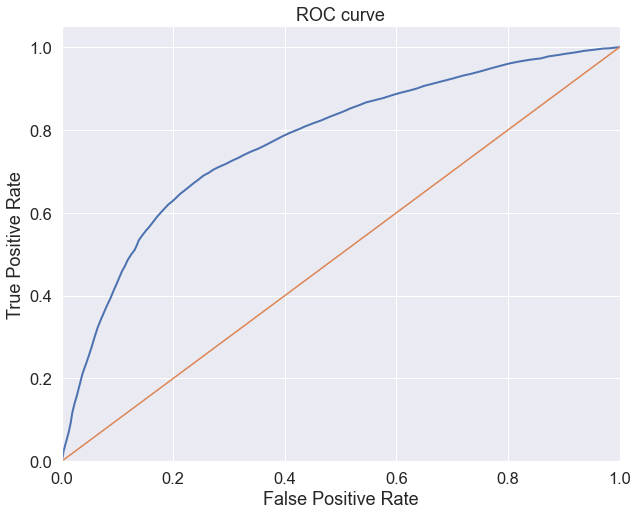

In [89]:
#Случайный лес
clf_rf = Pipeline([
    ('Features', feats),
    ('Classifier', RandomForestClassifier(random_state=42)),
])

metrics_rf = build_model(clf_rf, X_train, X_test, y_train, y_test)
metrics = metrics.append(metrics_rf, ignore_index=True)

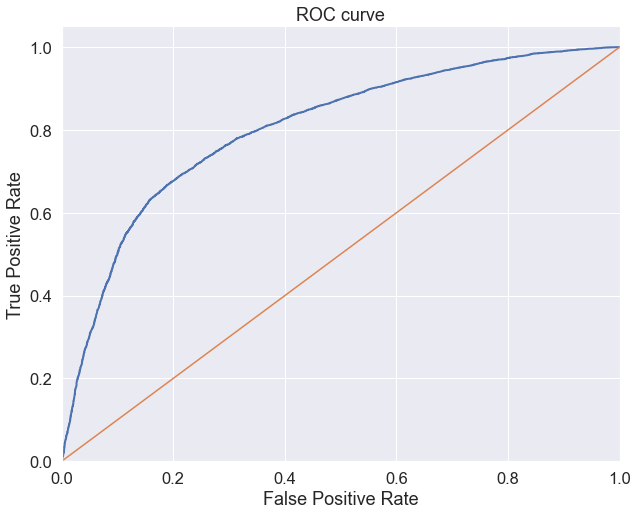

In [90]:
#Градиентный бустинг
clf_gb = Pipeline([
    ('Features', feats),
    ('Classifier', GradientBoostingClassifier(random_state=42)),
])

metrics_gb = build_model(clf_gb, X_train, X_test, y_train, y_test)
metrics = metrics.append(metrics_gb, ignore_index=True)

### Задание 2

Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

#### Решение

In [91]:
metrics

,precision,recall,f1_score,roc_auc,cv_roc_auc,cv_roc_auc_std,cnf_matrix
0,0.655534,0.837494,0.735426,0.785239,0.782094,0.003214,"[[4810, 3878], [1433, 7379]]"
1,0.652684,0.808670,0.722352,0.772244,0.774787,0.002694,"[[5002, 3686], [1751, 7061]]"
2,0.715684,0.779846,0.746389,0.803264,0.801833,0.004118,"[[5958, 2730], [1942, 6870]]"


### Задание 3

Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока
- стоимость лечения 15000р, если сделали тест и начали лечить вовремя
- стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
- стоимость теста 1400р

#### Решение

In [96]:
metod = 0 #Логистическая регрессия
TN = metrics['cnf_matrix'][metod][0][0]
FN = metrics['cnf_matrix'][metod][1][0]
TP = metrics['cnf_matrix'][metod][1][1]
FP = metrics['cnf_matrix'][metod][0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

rubl_1 = (FN + TP) * rubl_late_treatment
print('расходы, если не делать тест и ждать симптомов:', rubl_1)
rubl_test_all = np.sum(metrics['cnf_matrix'][metod]) * rubl_test + (FN + TP) * rubl_early_treatment
print('расходы, если делать тест всем и лечить группу большых:', rubl_test_all)
rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML)
print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML)

расходы, если не делать тест и ждать симптомов: 176240000
расходы, если делать тест всем и лечить группу большых: 156680000
расходы, если использовать МЛ: 155104800
Расходы "решение не делать тесты - расходы с МL:" 21135200
Расходы "решение не делать тесты - расходы сделать тесты всем": 19560000
Расходы "сделать тесты всем - решение делать тесты ML": 1575200


In [97]:
metod = 1 #Случайный лес
TN = metrics['cnf_matrix'][metod][0][0]
FN = metrics['cnf_matrix'][metod][1][0]
TP = metrics['cnf_matrix'][metod][1][1]
FP = metrics['cnf_matrix'][metod][0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

rubl_1 = (FN + TP) * rubl_late_treatment
print('расходы, если не делать тест и ждать симптомов:', rubl_1)
rubl_test_all = np.sum(metrics['cnf_matrix'][metod]) * rubl_test + (FN + TP) * rubl_early_treatment
print('расходы, если делать тест всем и лечить группу большых:', rubl_test_all)
rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML)
print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML)

расходы, если не делать тест и ждать симптомов: 176240000
расходы, если делать тест всем и лечить группу большых: 156680000
расходы, если использовать МЛ: 155980800
Расходы "решение не делать тесты - расходы с МL:" 20259200
Расходы "решение не делать тесты - расходы сделать тесты всем": 19560000
Расходы "сделать тесты всем - решение делать тесты ML": 699200


In [98]:
metod = 2 #Градиентный бустинг
TN = metrics['cnf_matrix'][metod][0][0]
FN = metrics['cnf_matrix'][metod][1][0]
TP = metrics['cnf_matrix'][metod][1][1]
FP = metrics['cnf_matrix'][metod][0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

rubl_1 = (FN + TP) * rubl_late_treatment
print('расходы, если не делать тест и ждать симптомов:', rubl_1)
rubl_test_all = np.sum(metrics['cnf_matrix'][metod]) * rubl_test + (FN + TP) * rubl_early_treatment
print('расходы, если делать тест всем и лечить группу большых:', rubl_test_all)
rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML)
print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML)

расходы, если не делать тест и ждать симптомов: 176240000
расходы, если делать тест всем и лечить группу большых: 156680000
расходы, если использовать МЛ: 155330000
Расходы "решение не делать тесты - расходы с МL:" 20910000
Расходы "решение не делать тесты - расходы сделать тесты всем": 19560000
Расходы "сделать тесты всем - решение делать тесты ML": 1350000


### Задание 4

Сделать выводы о том, какая модель справилась с задачей лучше других

#### Решение

По всем метрикам, кроме Recall, градиентный бустинг справился с выявлением закономерностей в датасете лучше всех и оказался наиболее точен.

Если бы было решено, что Recall важнее чем Precision, то лучше воспользоваться логистической регрессией, если важен Precision, то градиентным бустингом.

### Задание 5

*Найти порог классификации по деньгам для лучшей модели
- Стоимость лечения 15000р, если сделали тест и начали лечить вовремя
- Стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
- Стоимость теста 1400р

#### Решение

-